## Импорты и установка модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

## Используемые функции

In [5]:
#функция для mae
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_idx = np.where(y_true != 0)[0]
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

In [6]:
#функция проверки стационарности (нужна по логике дальше в коде)
def check_stationarity(series, window=12):
    rolmean = series.rolling(window=window).mean()
    rolstd = series.rolling(window=window).std()

    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value

    plt.figure(figsize=(12, 6))
    plt.plot(series, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print("Results of Dickey-Fuller Test:")
    print(dfoutput)

    return dfoutput['p-value'] <= 0.05

In [9]:
#подготовка данных для моделей
def preprocess_data(df, test_size=0.0406050955, target_col='Close/Last'):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    if target_col not in df.columns:
        raise ValueError(f"Column '{target_col}' not found in DataFrame")

    if df[target_col].isnull().sum() > 0:
        print(f"Пропуски {df[target_col].isnull().sum()} надо заполнить")
        df[target_col] = df[target_col].fillna(method='ffill')

    exog_cols = [col for col in df.columns if col != target_col]
    if exog_cols:
        scaler = StandardScaler()
        df[exog_cols] = scaler.fit_transform(df[exog_cols])

    split_idx = int(len(df) * (1 - test_size))
    train = df.iloc[:split_idx]
    test = df.iloc[split_idx:]

    return train.drop(target_col, axis=1), test.drop(target_col, axis=1), \
           train[target_col], test[target_col], scaler if exog_cols else None

## Основная функция расчета ACF, PACF, прогноза и величины ошибок

Loading data...
Preprocessing data...
Splitting data...

Data Summary:
Train period: 2020-03-19 00:00:00 to 2025-01-02 00:00:00
Test period: 2025-01-03 00:00:00 to 2025-03-18 00:00:00
Train size: 1251, Test size: 53
Unique y_train values: 1221

Evaluating models...

Checking stationarity...


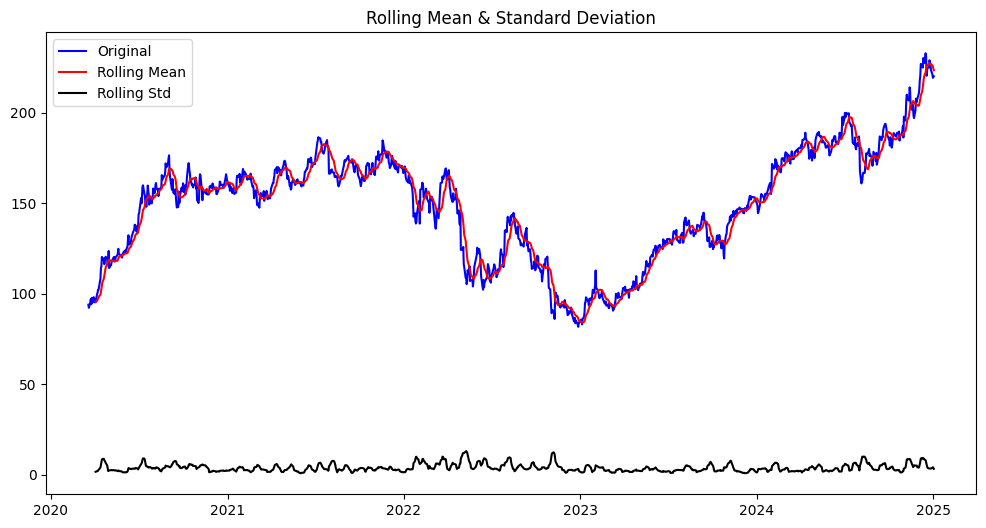

Results of Dickey-Fuller Test:
Test Statistic                   -1.443538
p-value                           0.561235
#Lags Used                        0.000000
Number of Observations Used    1250.000000
Critical Value (1%)              -3.435592
Critical Value (5%)              -2.863855
Critical Value (10%)             -2.568003
dtype: float64
Series is not stationary


<Figure size 1200x600 with 0 Axes>

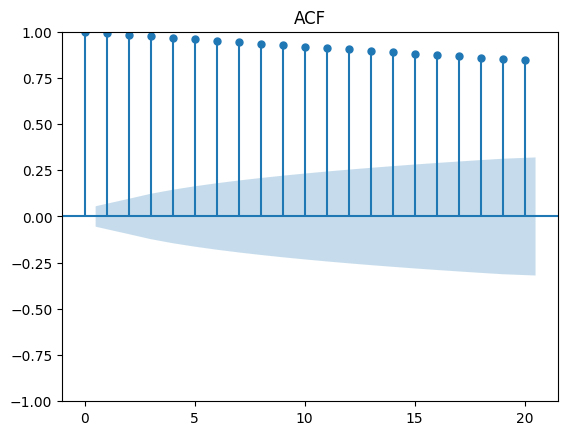

<Figure size 1200x600 with 0 Axes>

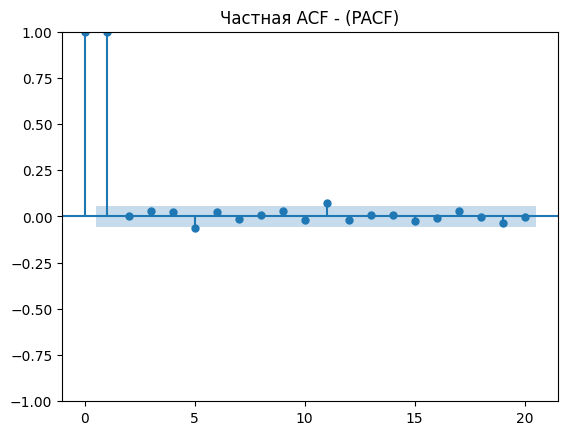


1. Fitting ARIMA model...

2. Fitting SARIMA model...

3. Fitting SARIMAX model...

Model Evaluation Metrics:
Model      MAE             MAPE (%)        RMSE            Parameters                    
ARIMA      11.9612         5.5277          14.1009         (2, 1, 2)                     
SARIMA     12.4168         5.8195          15.3357         ((1, 1, 1), (1, 1, 1, 5))     
SARIMAX    12.4084         5.8212          15.3805         ((1, 1, 1), (1, 1, 1, 5))     


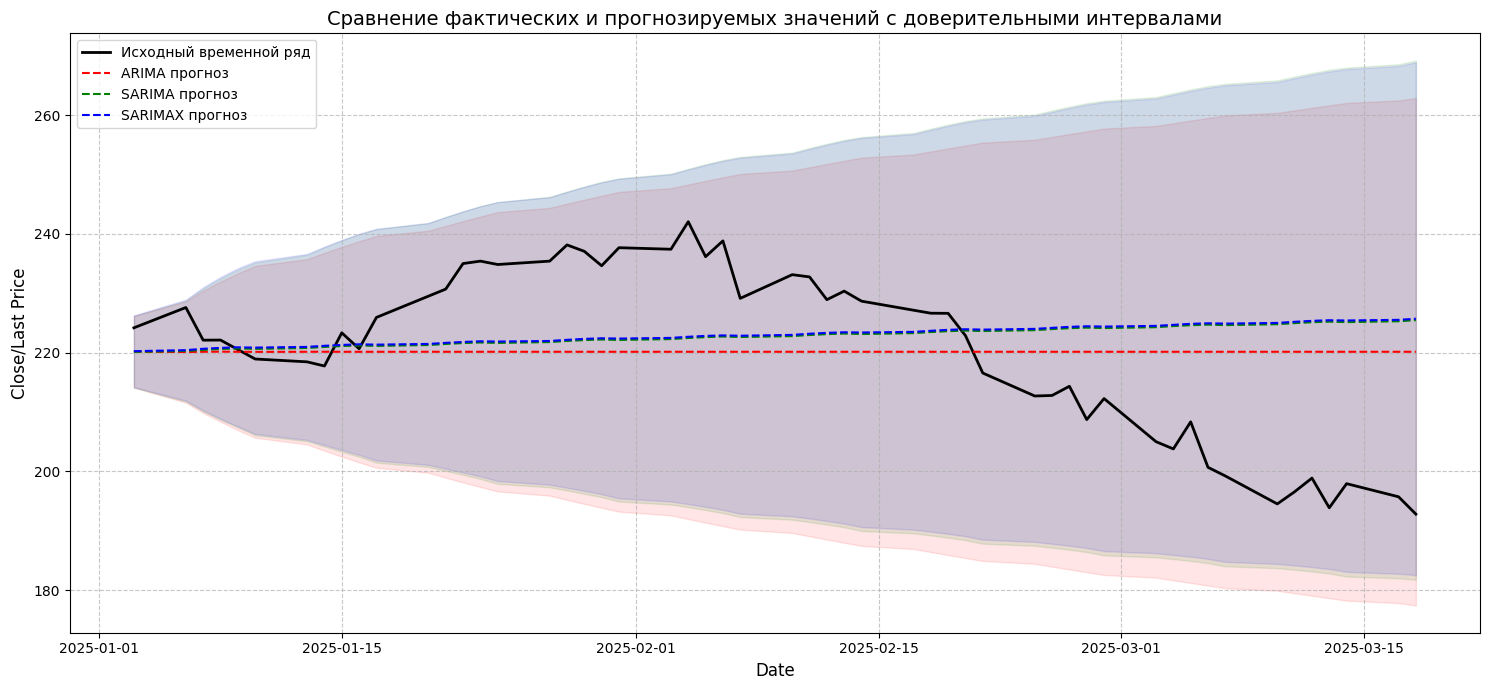

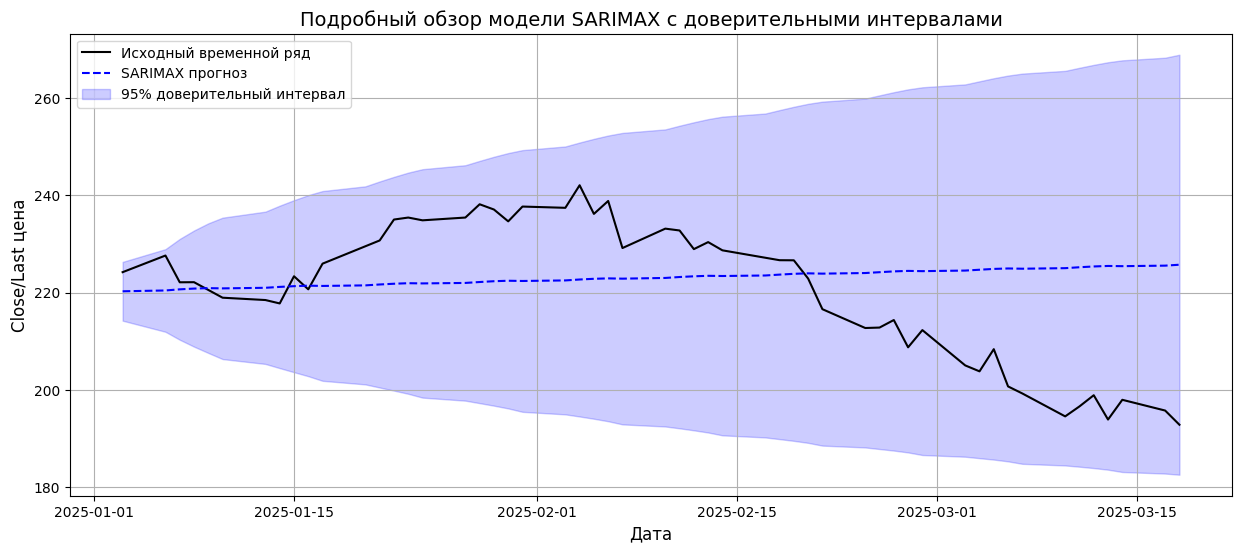

In [8]:
## основная функция в рамках которой все считается
def evaluate_models(X_train, y_train, X_test, y_test, exog_train=None, exog_test=None):
    if len(y_train) == 0 or len(y_test) == 0:
        raise ValueError("Train or test set is empty")

    print("\nChecking stationarity...")
    is_stationary = check_stationarity(y_train)
    print(f"Series is {'stationary' if is_stationary else 'not stationary'}")

    plt.figure(figsize=(12, 6))
    plot_acf(y_train, lags=20, alpha=0.05)
    plt.title('ACF')
    plt.show()

    plt.figure(figsize=(12, 6))
    plot_pacf(y_train, lags=20, alpha=0.05, method='ols')
    plt.title('Частная ACF - (PACF)')
    plt.show()

    results = []
    predictions = {}

    # 1. ARIMA модель с фиксированными параметрами
    print("\n1. Fitting ARIMA model...")
    try:
        model_arima = ARIMA(y_train, order=(2,1,2))
        model_arima_fit = model_arima.fit()
        preds_arima = model_arima_fit.get_forecast(steps=len(y_test))

        predictions['ARIMA'] = {
            'mean': preds_arima.predicted_mean,
            'lower': preds_arima.conf_int().iloc[:, 0],
            'upper': preds_arima.conf_int().iloc[:, 1]
        }

        mae = mean_absolute_error(y_test, preds_arima.predicted_mean)
        mape = mean_absolute_percentage_error(y_test, preds_arima.predicted_mean)
        rmse = sqrt(mean_squared_error(y_test, preds_arima.predicted_mean))
        results.append(('ARIMA', mae, mape, rmse, (2,1,2)))
    except Exception as e:
        print(f"ARIMA failed: {str(e)}")

    # 2. SARIMA модель с фиксированными параметрами
    print("\n2. Fitting SARIMA model...")
    try:
        model_sarima = SARIMAX(
            y_train,
            order=(1,1,1),
            seasonal_order=(1,1,1,5),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_sarima_fit = model_sarima.fit(disp=False)
        preds_sarima = model_sarima_fit.get_forecast(steps=len(y_test))

        predictions['SARIMA'] = {
            'mean': preds_sarima.predicted_mean,
            'lower': preds_sarima.conf_int().iloc[:, 0],
            'upper': preds_sarima.conf_int().iloc[:, 1]
        }

        mae = mean_absolute_error(y_test, preds_sarima.predicted_mean)
        mape = mean_absolute_percentage_error(y_test, preds_sarima.predicted_mean)
        rmse = sqrt(mean_squared_error(y_test, preds_sarima.predicted_mean))
        results.append(('SARIMA', mae, mape, rmse, ((1,1,1), (1,1,1,5))))
    except Exception as e:
        print(f"SARIMA не сработала: {str(e)}")

    # 3. SARIMAX модель (с экзогенными переменными)
    print("\n3. Fitting SARIMAX model...")
    if exog_train is not None and exog_test is not None and len(exog_train) > 0 and len(exog_test) > 0:
        try:
            model_sarimax = SARIMAX(
                y_train,
                exog=exog_train,
                order=(1,1,1),
                seasonal_order=(1,1,1,5),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_sarimax_fit = model_sarimax.fit(disp=False)
            preds_sarimax = model_sarimax_fit.get_forecast(
                steps=len(y_test),
                exog=exog_test
            )

            predictions['SARIMAX'] = {
                'mean': preds_sarimax.predicted_mean,
                'lower': preds_sarimax.conf_int().iloc[:, 0],
                'upper': preds_sarimax.conf_int().iloc[:, 1]
            }

            mae = mean_absolute_error(y_test, preds_sarimax.predicted_mean)
            mape = mean_absolute_percentage_error(y_test, preds_sarimax.predicted_mean)
            rmse = sqrt(mean_squared_error(y_test, preds_sarimax.predicted_mean))
            results.append(('SARIMAX', mae, mape, rmse, ((1,1,1), (1,1,1,5))))
        except Exception as e:
            print(f"SARIMAX не сработала: {str(e)}")
    else:
        print("не нашел признаки для SARIMAX, давай по новой")

    print("\nModel Evaluation Metrics:")
    print("{:<10} {:<15} {:<15} {:<15} {:<30}".format('Model', 'MAE', 'MAPE (%)', 'RMSE', 'Parameters'))
    for model, mae, mape, rmse, params in results:
        print(f"{model:<10} {mae:<15.4f} {mape:<15.4f} {rmse:<15.4f} {str(params):<30}")

    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, 'k-', linewidth=2, label='Исходный временной ряд')

    colors = ['r', 'g', 'b', 'm', 'c']
    for i, (model_name, preds) in enumerate(predictions.items()):
        plt.plot(y_test.index, preds['mean'],
                linestyle='--',
                color=colors[i % len(colors)],
                linewidth=1.5,
                label=f'{model_name} прогноз')
        plt.fill_between(y_test.index,
                        preds['lower'],
                        preds['upper'],
                        color=colors[i % len(colors)], alpha=0.1)

    plt.title('Сравнение фактических и прогнозируемых значений с доверительными интервалами', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close/Last Price', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return results, predictions

if __name__ == "__main__":
    print("Loading data...")
    df_main = pd.read_csv("/content/HistoricalData_1742404356306.csv", parse_dates=['Date'])
    df_exog = pd.read_excel("/content/for_sarimax_1.xlsx", engine="openpyxl")

    print("Preprocessing data...")
    df_main['Close/Last'] = df_main['Close/Last'].str.replace('[\$,]', '', regex=True).astype(float)
    df_main = df_main[['Date', 'Volume', 'Close/Last']].set_index('Date').sort_index()

    df_main = df_main.asfreq('B').interpolate(method='time')
    df_main['year'] = df_main.index.year

    df_exog = df_exog.replace([np.inf, -np.inf], np.nan)
    numeric_cols = df_exog.select_dtypes(include=[np.number]).columns
    df_exog[numeric_cols] = df_exog[numeric_cols].fillna(df_exog[numeric_cols].median())

    df_combined = df_main.join(df_exog.set_index('year'), on='year', how='left')
    df_combined = df_combined.drop('year', axis=1).fillna(method='ffill').fillna(0)

    print("Splitting data...")
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df_combined)

    print("\nData Summary:")
    print(f"Train period: {y_train.index.min()} to {y_train.index.max()}")
    print(f"Test period: {y_test.index.min()} to {y_test.index.max()}")
    print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")
    print(f"Unique y_train values: {len(y_train.unique())}")

    print("\nEvaluating models...")
    metrics, predictions = evaluate_models(X_train, y_train, X_test, y_test, X_train, X_test)

    if 'SARIMAX' in predictions:
        plt.figure(figsize=(15, 6))
        plt.plot(y_test.index, y_test, 'k-', label='Исходный временной ряд')
        plt.plot(y_test.index, predictions['SARIMAX']['mean'], 'b--', label='SARIMAX прогноз')
        plt.fill_between(y_test.index,
                        predictions['SARIMAX']['lower'],
                        predictions['SARIMAX']['upper'],
                        color='blue', alpha=0.2, label='95% доверительный интервал')
        plt.title('Подробный обзор модели SARIMAX с доверительными интервалами', fontsize=14)
        plt.xlabel('Дата', fontsize=12)
        plt.ylabel('Close/Last цена', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()